In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model
from losses import get_loss_f
from train import Trainer, Validator

# wt modules
from wavelet_transform import Wavelet_Transform, Attributer, get_2dfilts, initialize_filters
from utils import tuple_L1Loss, tuple_L2Loss, thresh_attrs, viz_list

## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

## initialize filter

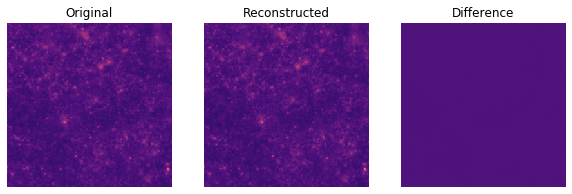

Recon=0.00000


In [3]:
# wavelet transform with initialization
wt_orig = Wavelet_Transform(wt_type='DWT', wave='db3', mode='symmetric', device='cuda', J=5)
viz_im_r(im[0], wt_orig.inverse(wt_orig(im))[0])
print("Recon={:.5f}".format(torch.norm(wt_orig.inverse(wt_orig(im)) - im)**2/im.size(0)))

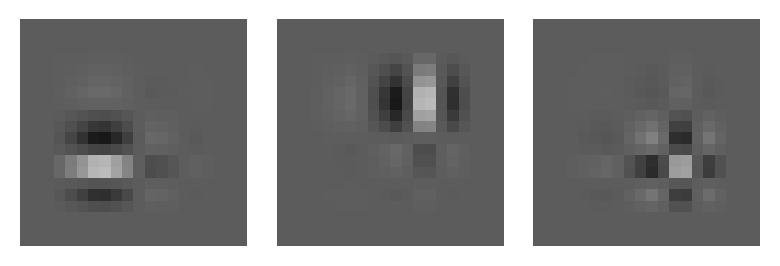

In [4]:
filt = get_2dfilts(wt_orig)
viz_list(filt, figsize=(4,4))

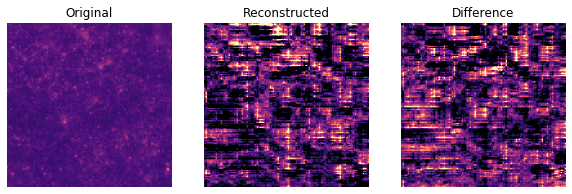

Recon=626.81769


In [25]:
wt = initialize_filters(wt_orig, init_level=1, noise_level=0.2)
filt = get_2dfilts(wt)
viz_im_r(im[0], wt.inverse(wt(im))[0])
print("Recon={:.5f}".format(torch.norm(wt.inverse(wt(im)) - im)**2/im.size(0)))

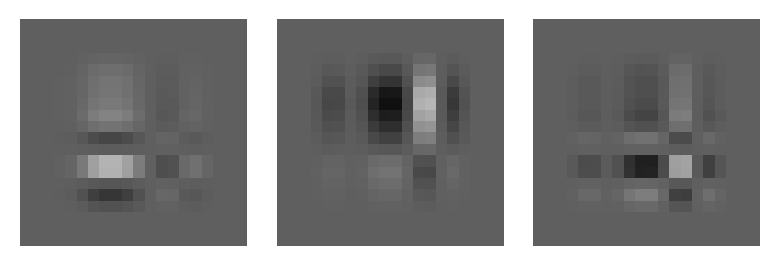

In [26]:
viz_list(filt, figsize=(4,4))

## optimize filter

In [7]:
# train
params = list(wt.xfm.parameters()) + list(wt.ifm.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)
loss_f = get_loss_f(lamL1attr=50)
trainer = Trainer(model, wt, Attributer, optimizer, loss_f, attr_methods='Saliency', device=device)
trainer(train_loader, epochs=10)

Starting Training Loop...
Train Epoch: 0 [15600/25000 (100%)]	Loss: 4508.408203
====> Epoch: 0 Average train loss: 4193.6280
Train Epoch: 1 [15600/25000 (100%)]	Loss: 5060.375000
====> Epoch: 1 Average train loss: 4835.0709
Train Epoch: 2 [15600/25000 (100%)]	Loss: 5164.905762
====> Epoch: 2 Average train loss: 5228.1952
Train Epoch: 3 [15600/25000 (100%)]	Loss: 5069.275879
====> Epoch: 3 Average train loss: 5271.1947
Train Epoch: 4 [15600/25000 (100%)]	Loss: 5141.596191
====> Epoch: 4 Average train loss: 5272.8628
Train Epoch: 5 [15600/25000 (100%)]	Loss: 5361.173828
====> Epoch: 5 Average train loss: 5273.0905
Train Epoch: 6 [15600/25000 (100%)]	Loss: 5543.714355
====> Epoch: 6 Average train loss: 5273.2655
Train Epoch: 7 [15600/25000 (100%)]	Loss: 5163.535645
====> Epoch: 7 Average train loss: 5272.9006
Train Epoch: 8 [15600/25000 (100%)]	Loss: 5588.234863
====> Epoch: 8 Average train loss: 5273.3078
Train Epoch: 9 [15600/25000 (100%)]	Loss: 5257.987305
====> Epoch: 9 Average train 

In [8]:
trainer(train_loader, epochs=10)

Starting Training Loop...
Train Epoch: 0 [15600/25000 (100%)]	Loss: 5508.919922
====> Epoch: 0 Average train loss: 5273.2354
Train Epoch: 1 [15600/25000 (100%)]	Loss: 5324.187012
====> Epoch: 1 Average train loss: 5255.8862
Train Epoch: 2 [15600/25000 (100%)]	Loss: 5296.088379
====> Epoch: 2 Average train loss: 5239.1675
Train Epoch: 3 [15600/25000 (100%)]	Loss: 5312.251465
====> Epoch: 3 Average train loss: 5218.1991
Train Epoch: 4 [15600/25000 (100%)]	Loss: 5374.615234
====> Epoch: 4 Average train loss: 5172.3786
Train Epoch: 5 [15600/25000 (100%)]	Loss: 5246.770020
====> Epoch: 5 Average train loss: 5172.2596
Train Epoch: 6 [15600/25000 (100%)]	Loss: 5270.522461
====> Epoch: 6 Average train loss: 5172.2821
Train Epoch: 7 [15600/25000 (100%)]	Loss: 5125.837402
====> Epoch: 7 Average train loss: 5128.7385
Train Epoch: 8 [15600/25000 (100%)]	Loss: 4911.717285
====> Epoch: 8 Average train loss: 5111.4443
Train Epoch: 9 [15600/25000 (100%)]	Loss: 5089.528320
====> Epoch: 9 Average train 

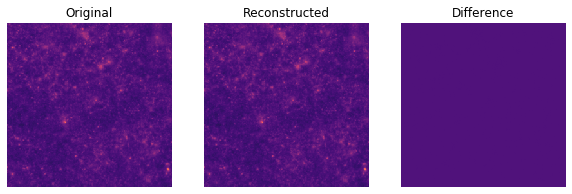

Recon=0.00000


In [9]:
filt = get_2dfilts(wt)
viz_im_r(im[0], wt.inverse(wt(im))[0])
print("Recon={:.5f}".format(torch.norm(wt.inverse(wt(im)) - im)**2/im.size(0)))

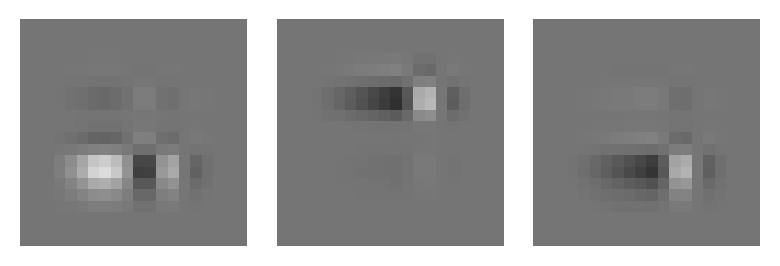

In [10]:
viz_list(filt, figsize=(4,4))

In [1]:
loss_v = get_loss_f(lamL1attr=1)
validator = Validator(model, wt, Attributer, loss_v, attr_methods='Saliency', device=device)
_, rec_loss, L1attr_loss = validator(test_loader)

print("\nRecon={:.5f} L1attr={:.5f}".format(rec_loss, L1attr_loss))

NameError: name 'get_loss_f' is not defined

In [12]:
loss_v = get_loss_f(lamL1attr=1)
validator = Validator(model, wt_orig, Attributer, loss_v, attr_methods='Saliency', device=device)
_, rec_loss, L1attr_loss = validator(test_loader)

print("\nRecon={:.5f} L1attr={:.5f}".format(rec_loss, L1attr_loss))

Test: [496/2000 (97%)]	Loss: 96.1083917
Recon=0.00000 L1attr=93.83803
